Training instances: (40, 224, 224, 3), Test instances: (21, 224, 224, 3)


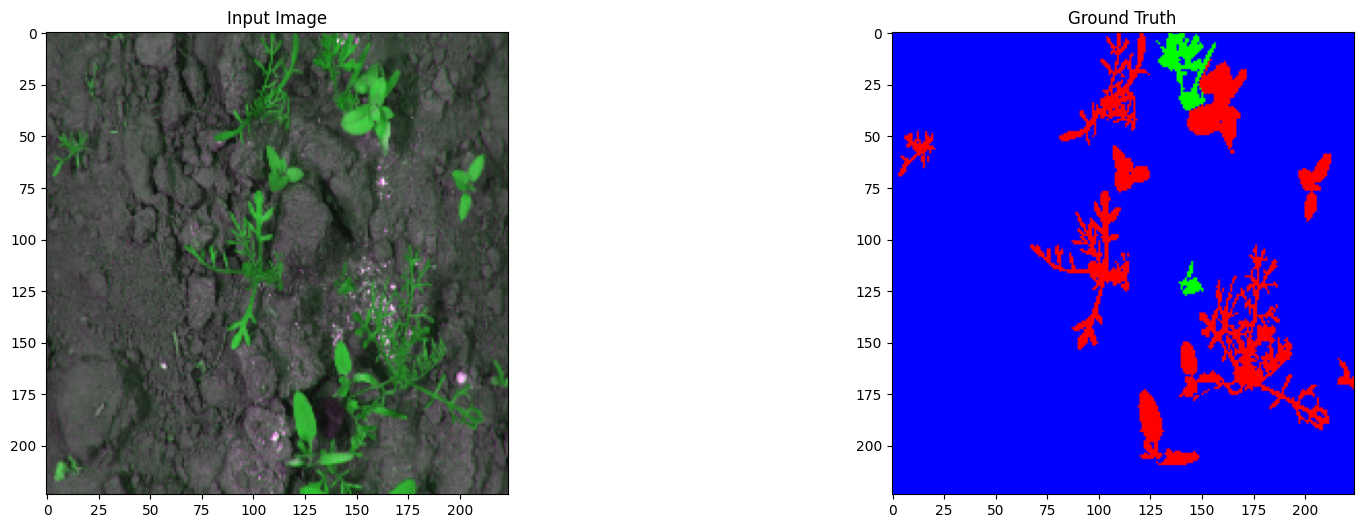

In [4]:
import numpy as np
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
import tensorflow as tf
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(1)
tf.random.set_seed(1)

# Load the segmentation dataset
def load_segmentation_data():
    data = np.load('/content/sample_data/segmentation_data.npz')
    train_x = data['train_x']
    train_y = data['train_y']
    test_x = data['test_x']
    test_y = data['test_y']
    return train_x, train_y, test_x, test_y

train_x, train_y, test_x, test_y = load_segmentation_data()
print(f"Training instances: {train_x.shape}, Test instances: {test_x.shape}")

# Visualize data
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(train_x[0])
plt.subplot(1, 2, 2)
plt.title("Ground Truth")
plt.imshow(train_y[0], cmap='gray')
plt.show()

In [5]:


# Define the U-Net model
def unet_model(input_shape=(224, 224, 3), num_classes=3):
    inputs = layers.Input(input_shape)

    # Downsampling
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Upsampling
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model



In [6]:
# # Define custom loss function for segmentation
# def custom_segmentation_loss(y_true, y_pred):
#     """
#     Custom loss function: Categorical crossentropy summed/averaged over all spatial positions.
#     Args:
#         y_true: Ground truth labels, one-hot encoded.
#         y_pred: Predicted probabilities from the model.
#     Returns:
#         Loss value (scalar).
#     """
#     # Flatten spatial dimensions for per-pixel cross-entropy calculation
#     y_true_flat = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
#     y_pred_flat = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

#     # Compute categorical cross-entropy
#     loss = tf.keras.losses.categorical_crossentropy(y_true_flat, y_pred_flat)
#     return tf.reduce_mean(loss)  # Average over all pixels

def custom_segmentation_loss(y_true, y_pred):
    """
    Custom loss function: Implements the formula for cross-entropy loss.
    Args:
        y_true: Ground truth labels, one-hot encoded.
        y_pred: Predicted probabilities from the model.
    Returns:
        Loss value (scalar).
    """
    # Flatten spatial dimensions for per-pixel cross-entropy calculation
    s_i = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])
    y_true_flat = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])

    # Compute cross-entropy manually using the formula
    epsilon = 1e-7  # To prevent log(0)
    s_i = tf.clip_by_value(s_i, epsilon, 1 - epsilon)  # Clipping to avoid numerical instability
    p_y_given_x = -tf.reduce_sum(y_true_flat * tf.math.log(s_i), axis=1)

    # Average over all pixels
    return tf.reduce_mean(p_y_given_x)

In [7]:

# Compile the model with the custom loss function
model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=custom_segmentation_loss,
              metrics=['accuracy', MeanIoU(num_classes=3)])

# Train the model
history = model.fit(train_x, train_y, validation_split=0.2, epochs=10, batch_size=8)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 206s 50s/step - accuracy: 0.5543 - loss: 0.9384 - mean_io_u: 0.3333 - val_accuracy: 0.8943 - val_loss: 0.4472 - val_mean_io_u: 0.3333
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 193s 49s/step - accuracy: 0.9303 - loss: 0.3404 - mean_io_u: 0.3333 - val_accuracy: 0.8943 - val_loss: 0.4121 - val_mean_io_u: 0.3333
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 203s 50s/step - accuracy: 0.9303 - loss: 0.2928 - mean_io_u: 0.3333 - val_accuracy: 0.8943 - val_loss: 0.3715 - val_mean_io_u: 0.3333
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 208s 50s/step - accuracy: 0.9303 - loss: 0.2630 - mean_io_u: 0.3333 - val_accuracy: 0.8943 - val_loss: 0.3176 - val_mean_io_u: 0.3333
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 196s 50s/step - accuracy: 0.9303 - loss: 0.2225 - mean_io_u: 0.3333 - val_accuracy: 0.8943 - val_loss: 0.2562 - val_mean_io_u: 0.3333
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.9295 - loss: 0.1817 - mean_io_u: 0.3333 Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 210s 52s/ste

In [8]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}")


Layer 0: input_layer
Layer 1: conv2d
Layer 2: conv2d_1
Layer 3: max_pooling2d
Layer 4: conv2d_2
Layer 5: conv2d_3
Layer 6: max_pooling2d_1
Layer 7: conv2d_4
Layer 8: conv2d_5
Layer 9: max_pooling2d_2
Layer 10: conv2d_6
Layer 11: conv2d_7
Layer 12: max_pooling2d_3
Layer 13: conv2d_8
Layer 14: conv2d_9
Layer 15: conv2d_transpose
Layer 16: concatenate
Layer 17: conv2d_10
Layer 18: conv2d_11
Layer 19: conv2d_transpose_1
Layer 20: concatenate_1
Layer 21: conv2d_12
Layer 22: conv2d_13
Layer 23: conv2d_transpose_2
Layer 24: concatenate_2
Layer 25: conv2d_14
Layer 26: conv2d_15
Layer 27: conv2d_transpose_3
Layer 28: concatenate_3
Layer 29: conv2d_16
Layer 30: conv2d_17
Layer 31: conv2d_18


In [17]:
#Create a new model that outputs intermediate layer activations
input_image = train_x[0:1]
intermediate_model = Model(inputs=model.input, outputs=model.get_layer('max_pooling2d_3').output)

# Pass the input through the intermediate model
intermediate_output = intermediate_model.predict(input_image)
print("Intermediate output shape:", intermediate_output.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
Intermediate output shape: (1, 14, 14, 512)


In [11]:
# Extract a single input image from the dataset
input_image = train_x[0:1]  # Select the first image and add a batch dimension

# Forward pass the input through the model
output = model(input_image)

# Print the shape of the input and output
print(f"Input shape: {input_image.shape}")
print(f"Output shape: {output.shape}")


Input shape: (1, 224, 224, 3)
Output shape: (1, 224, 224, 3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.9620 - loss: 0.1061 - mean_io_u: 0.3333
Test Loss: 0.10605933517217636, Test Accuracy: 0.9620288610458374
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step


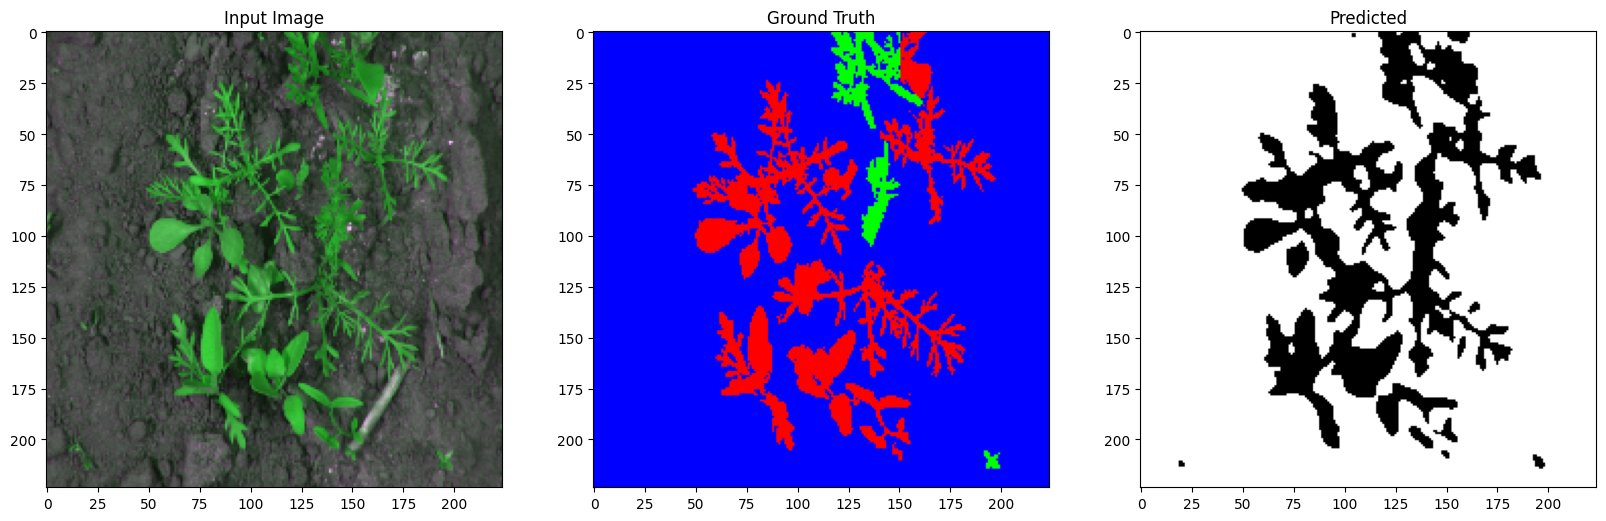

In [13]:

# Evaluate the model
evaluation = model.evaluate(test_x, test_y)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")

# Visualize predictions
predictions = model.predict(test_x)
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(test_x[0])

plt.subplot(1, 3, 2)
plt.title("Ground Truth")
plt.imshow(test_y[0], cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted")
plt.imshow(np.argmax(predictions[0], axis=-1), cmap='gray')
plt.show()


In [14]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 224, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 112, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 56, 56, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 14, 14, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 14, 14, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 14, 14, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 28, 28, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 93,095,627 (355.13 MB)

 Trainable params: 31,031,875 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,063,752 (236.75 MB)

In [16]:
# plt.imshow(test_x[0])
